## Kaggle Google Landmark - Model 
A Python note Book which provides models for the Kaggle Google Landmark 
The Notebook assume that there is a set of images in classes folders 
Divided into train test and validation subdirectories 


## Load Libraries 
Loading the required libraries 
The implementation is based on the Keras/TenserFlow Python libraries 

In [0]:
from keras import models
from keras import layers
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,Dropout,ZeroPadding2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Model

import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import tarfile
import urllib
import urllib.request
import hashlib
import random
import requests
import random
import shutil
import re 
from shutil import copyfile
import urllib
from google.colab import files
import glob
import csv
import cv2
from keras.models import load_model
import math
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import tensorflow as tf
import keras




Using TensorFlow backend.


## General Settings 

In [0]:
#Column/Row length when printing DataFrames 
pd.set_option('display.max_colwidth', -1)

#Root Directory 
Root_Directory = "/content/gdrive/My Drive/Colab Notebooks/Google Landmark/"
Meta_Data_Directory = "/content/gdrive/My Drive/Colab Notebooks/Google Landmark/"


## GPU Status 
Check avilabilty of the GPU

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
!df -h .

Gen RAM Free: 12.7 GB  | Proc size: 330.6 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   28G  313G   8% /


## Read Data 

Read the labels from Google drive 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Hello Google Drive!

## Read Data 
Download the labels and metadata

In [0]:
#Read the train.csv from Google drive - This file has all images names and labels of the landmark (Landmark ID)
DF_Labels = pd.read_csv(Meta_Data_Directory+"train.csv")


In [0]:
DF_Labels.loc[DF_Labels['landmark_id']==2545]

,id,url,landmark_id
1490735,cfcedb28f0a3826a,https://upload.wikimedia.org/wikipedia/commons/6/6c/Ravine_Patates_%C3%A0_Durand.JPG,2545


## Analyze labels 

In [0]:
print(DF_Labels.shape)
DF_Labels.head()

(4132914, 3)


,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons/b/b5/Observatoriet_v%C3%A4derkammer_2013a.jpg,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/6/63/Ecosse200996-1.jpg,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/2/2c/Pirmasens_Dynamikum.jpg,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons/0/02/Occidental_Vertical.jpg,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons/5/51/Looking_downstream_from_the_footbridge_over_the_Severn_-_geograph.org.uk_-_532337.jpg,2474


Total number of diffrent types of Landmarks: 203094
Total number of files 4132914


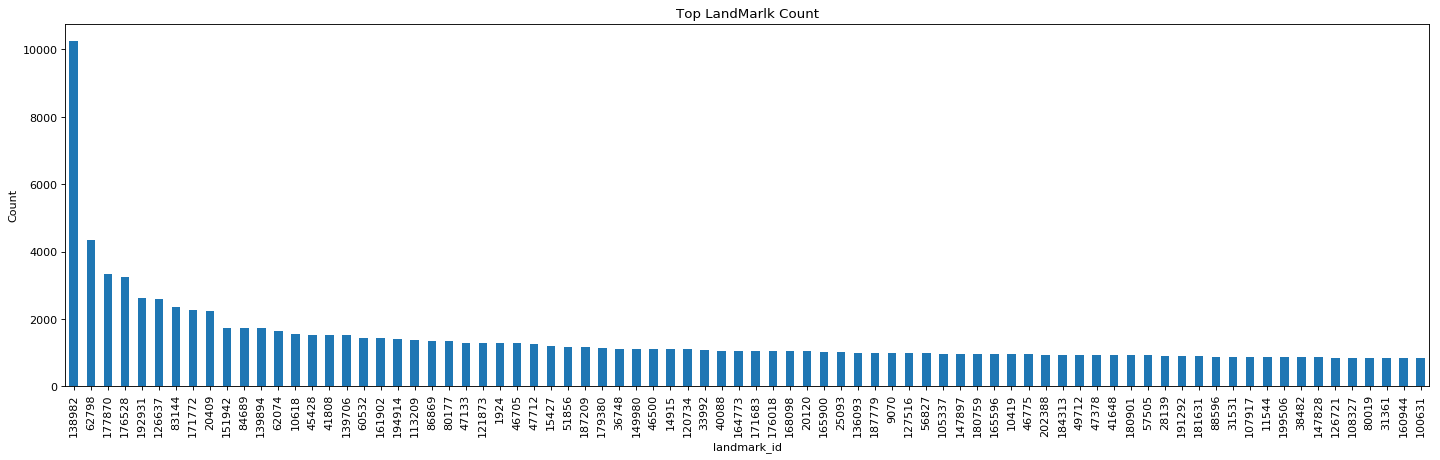

In [0]:
from matplotlib.pyplot import figure
x = (DF_Labels.groupby(['landmark_id']).size()).sort_values(ascending=False)

print("Total number of diffrent types of Landmarks:",len(x))
print("Total number of files",sum(x))
figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Top LandMarlk Count')
plt.ylabel('Count')
plt.xlabel('LandMark ID')
x.head(80).plot.bar()

In [0]:
random.seed(1234)
landmark_list = [str(x) for x in list(range(1000,3000))]
data_sample = DF_Labels[DF_Labels['landmark_id'].isin(landmark_list)]

There are: 4132914 Images in the Entire set
There are: 80746 Images in the Sample set


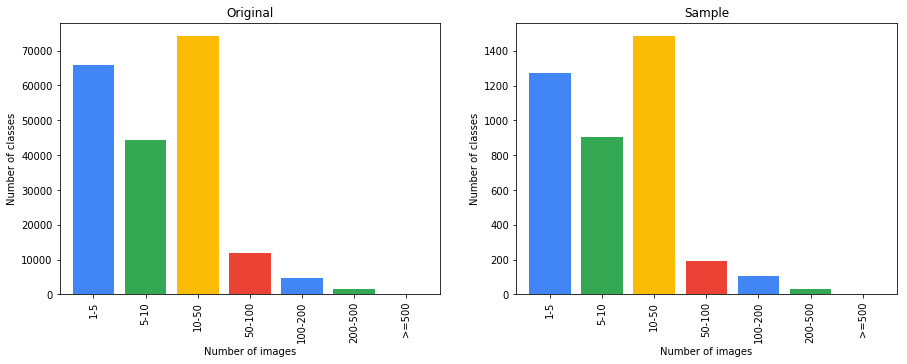

In [0]:
colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500', '>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))



def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())

    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
    

print("There are:",DF_Labels.shape[0], "Images in the Entire set")
print("There are:",data_sample.shape[0], "Images in the Sample set")
plot_distribution(DF_Labels, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)


## Test data
Download test data

In [0]:
from zipfile import ZipFile

#Extract the test.csv file from the Zip file 
zf = zipfile.ZipFile(Meta_Data_Directory+'test.csv.zip', mode='r')
zf.extractall()
zf.close()
DF_Test_Labels = pd.read_csv("test.csv")
print("There are :",DF_Test_Labels.shape[0],"Test images")




There are : 117703 Test images


## Fetch Images 

## Diplay images 

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 

def displayLandmarkImagesLarge(urls, category_name):
    img_style = "width: 200px; height:160px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(16).iteritems()])
    display(HTML(images_list))

category = DF_Labels['landmark_id'].value_counts().keys()[1999]
urls = DF_Labels[DF_Labels['landmark_id'] == category]['url']
displayLandmarkImagesLarge(urls, "")

## Extract Images 
Copy the zip file (from the google drive) with the images and extract it 

In [0]:
#Create Data Directory 
if not os.path.exists("Data"):
  !mkdir Data


In [0]:
#Copy the Tar/Zip file of the images 
!cp "/content/gdrive/My Drive/Colab Notebooks/Google Landmark/image.zip"  "./"

In [0]:
zf = zipfile.ZipFile("image.zip", mode='r')
zf.extractall("Data")
zf.close()

In [0]:
!cp -r Data/temp/train_images_model Data
!cp -r Data/temp/validation_images_model Data
!rm -r Data/temp
!ls Data

moved_images  train_images_model  validation_images_model


In [0]:
for x in range(2000,3000):
  if not os.path.exists("Data/train_images_model/"+str(x)):
    os.mkdir("Data//train_images_model/"+str(x))
  if not os.path.exists("Data/validation_images_model/"+str(x)):
    os.mkdir("Data//validation_images_model/"+str(x))

## Predictions using weights from ImageNet
Before proceeding with any model training, VGG16 architecture trained on Imagenet dataset is picked up and is used to predict on the images that we had. Observation: Imagenet weights are successfully able to capture the generic features from landmarks.

Instructions for updating:
Colocations handled automatically by placer.
40960/35363 [==================================] - 0s 5us/step
Predicted: [('n02980441', 'castle', 0.421175), ('n03781244', 'monastery', 0.36050403), ('n03028079', 'church', 0.14520133)]


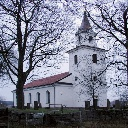

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from IPython.display import Image, display

model =VGG16(weights = 'imagenet', include_top = True)

img_path = r'Data/train_images_model/1030/0b0331c0da1cca13.jpg'
img = image.load_img(img_path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

preds = model.predict(x)
print ('Predicted:', decode_predictions(preds, top = 3)[0])


                                                                              

display(Image('Data/train_images_model/1030/0b0331c0da1cca13.jpg'))
# 0a0667fc2436a04b = stupa (17%)
# 0b48dd3b81d5b6ba = triumphal_arch(25%)

In [0]:
train_data_dir = 'Data/train_images_model'
validation_data_dir = 'Data/validation_images_model'

#counts the number of files in subdirectories of a given directory. 
#outputs the count of images and label of each image in order of reading.

def count(dir):
    i = 1000
    count = []
    while i <= 2999:
        f = str(i)
        #print (f)
        for root, dirs, files in os.walk(dir +'/'+ f):  # loop through startfolders
            for pic in files:
                count.append(f) 
               
        i += 1
    print (len(count))
    return ([len(count),count])

nb_train_samples = count(train_data_dir)
nb_validation_samples = count(validation_data_dir)

# nb_train/validation_samples is a list of lists of the format [len(count),count]. len(count) is the total number of images in 
# train/validation folder. count is a list of class labels i.e. landmark IDs of the images read.

33730
7424


## Count Directories and Files 
Count all sub directories and files in the train and validation sets

In [0]:
counter=collections.Counter(nb_train_samples[1])
print(counter.keys())
print(counter.values())
counter.most_common(10)

dict_keys(['1000', '1002', '1003', '1006', '1007', '1008', '1009', '1011', '1012', '1013', '1014', '1015', '1018', '1019', '1022', '1025', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1038', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1058', '1059', '1060', '1061', '1062', '1063', '1064', '1066', '1067', '1068', '1069', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1083', '1084', '1085', '1088', '1090', '1091', '1095', '1097', '1098', '1099', '1100', '1101', '1103', '1104', '1105', '1106', '1108', '1110', '1113', '1114', '1116', '1118', '1119', '1120', '1121', '1122', '1123', '1124', '1125', '1127', '1129', '1130', '1131', '1132', '1135', '1137', '1138', '1140', '1141', '1142', '1145', '1146', '1148', '1150', '1152', '1153', '1154', '1155', '1156', '1157', '1159', '1161', '1163', '1164', '1165', '1166', '1167', '1171', '1173', '1174

[('1924', 794),
 ('1127', 466),
 ('2079', 463),
 ('1685', 345),
 ('2474', 344),
 ('1346', 252),
 ('2733', 251),
 ('1189', 245),
 ('2185', 235),
 ('1049', 227)]

In [0]:
#Check for missing classes 
train_dic = list(counter.keys())
ref = list(range(1000,3000))
ref = [str(item) for item in ref]
set(ref).difference(set(train_dic))


In [0]:
# Print validation classes and their sizes 
import collections
import operator
counter=collections.Counter(nb_validation_samples[1])
#print(counter.keys())
#print(counter.values())
sorted_counter = dict(sorted(counter.items(), key=operator.itemgetter(1),reverse=True))
class_list = list(sorted_counter.keys())
class_list = class_list[0:1500]
(class_list)

In [0]:
train_data_dir = 'Data/train_images_model'
validation_data_dir = 'Data/validation_images_model'

#counts the number of files in subdirectories of a given directory. 
#outputs the count of images and label of each image in order of reading.

def count(dir):
    i = 1000
    count = []
    while i <= 2999:
        f = str(i)
        #print (f)
        for root, dirs, files in os.walk(dir +'/'+ f):  # loop through startfolders
            for pic in files:
                if (f in class_list):
                  count.append(f) 
               
        i += 1
    print (len(count))
    return ([len(count),count])

nb_train_samples = count(train_data_dir)



32256


In [0]:
nb_train_samples

In [0]:
#Manual removal of images - in order to gurentee that the overall number divide by the batch size

### Remove images from the train data set 
CL = '1924' #class from which to move images
NI = 272 #Number of images to be moved

i = 0
for files in os.listdir(r'Data/train_images_model/' + CL):    # loop through startfolders
            i+=1
            inpath = r'Data/train_images_model/' + CL + '/' + files
            outpath = r'Data/moved_images' 
            shutil.move(inpath, outpath)
            if i == NI:
                break
                
          
                
# Remove images from the validation data set 
CL = '1924' #class from which to move images
NI = 86 #Number of images to be moved
i=0
for files in os.listdir(r'Data/validation_images_model/' + CL):    # loop through startfolders
            i+=1
            inpath = r'Data/validation_images_model/' + CL + '/' + files
            outpath = r'Data/moved_images' 
            shutil.move(inpath, outpath)
            if i == NI:
                break
                
              

In [0]:
#Remove some problmatic files 
!rm 'Data/train_images_model/2162/d283284e0eb15ed0.jpg'
!rm 'Data/train_images_model/2474/da768cf87103075a.jpg'
!rm 'Data/validation_images_model/1453/d876bceade04db19.jpg'

In [0]:


img_width, img_height = 128, 128 # dimensions of downloaded images.
top_model_weights_path = 'bottleneck_fc_model.h5' # A file with this name would be saved later in the code
epochs = 5
batch_size = 128 #As found in the previous step
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range = 0.5,
                                 brightness_range = [0.5,1.5])

#     build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
    print ('start1')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        classes=ref, # this means our generator will only yield batches of data, no labels
        shuffle=False) # our data will be in order
    
#     the predict_generator method returns the output of a model, given a generator that yields batches of numpy data
    print ('start2')
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples[0] // batch_size) 
    print ('bottleneck_features_trained')
    
    
    with open('bottleneck_features_train.npy', 'wb') as features_train_file:
        np.save(features_train_file, bottleneck_features_train)
    print ('Train done')
    


    datagen = ImageDataGenerator(rescale=1. / 255) #No image augmentation in validation dataset
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        classes=ref,
        shuffle=False)
    print ('validation predict start')
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples[0] // batch_size)
    
    with open('bottleneck_features_validation.npy', 'wb') as features_validation_file:
        np.save(features_validation_file, bottleneck_features_validation)
    print ('validation done')
save_bottleneck_features()

start1
Found 33730 images belonging to 2000 classes.
start2


KeyboardInterrupt: ignored

### Initializing the weights on top 3 layers

In [0]:
epochs = 15
batch_size = 940
import numpy as np

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(nb_train_samples[1])
    train_labels = [str(int(train_label) - 1000) for train_label in train_labels] 
    #Had to subtract 1000 because class labels should start from 0. In this case, class labels had a range from 1000 to 2999. 
#     print (train_labels)
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    
    validation_labels = np.array(nb_validation_samples[1])
    validation_labels = [str(int(validation_label) - 1000) for validation_label in validation_labels]
    print(len(validation_data))
#     print (validation_labels)
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    n_class = 2000 #number of classes fed to the model
    model.add(Dense(n_class, activation='softmax'))
    
    
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    print(len(validation_labels),n_class)
    train_labels = to_categorical(train_labels, n_class)
   
    validation_labels = to_categorical(validation_labels, n_class)
    
    print ('model fit starting')
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

train_top_model()

7424
7424 2000
model fit starting
Train on 32256 samples, validate on 7424 samples
Epoch 1/15
32256/32256 [==============================] - 4s 118us/step - loss: 6.7902 - acc: 0.0181 - val_loss: 6.5858 - val_acc: 0.0228
Epoch 2/15
32256/32256 [==============================] - 1s 46us/step - loss: 6.4677 - acc: 0.0265 - val_loss: 6.7281 - val_acc: 0.0245
Epoch 3/15
32256/32256 [==============================] - 1s 45us/step - loss: 6.2833 - acc: 0.0309 - val_loss: 6.8061 - val_acc: 0.0172
Epoch 4/15
32256/32256 [==============================] - 1s 45us/step - loss: 6.1078 - acc: 0.0374 - val_loss: 6.9268 - val_acc: 0.0183
Epoch 5/15
32256/32256 [==============================] - 1s 45us/step - loss: 5.9308 - acc: 0.0458 - val_loss: 7.1082 - val_acc: 0.0206
Epoch 6/15
32256/32256 [==============================] - 1s 45us/step - loss: 5.7693 - acc: 0.0530 - val_loss: 7.3003 - val_acc: 0.0290
Epoch 7/15
32256/32256 [==============================] - 1s 45us/step - loss: 5.5947 - acc: 0

## Initializing the weights on top 3 layers

In [0]:
img_width, img_height = 128, 128
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'Data/train_images_model'
validation_data_dir = 'Data/validation_images_model'
batch_size = 240
epochs = 32
def trainCNN():

    # build the VGG16 network

    base_model = applications.VGG16(weights='imagenet',include_top= False,input_shape=(128,128,3))
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dense(256, activation='relu'))
    n_class = 2000
    top_model.add(Dense(n_class, activation='softmax'))
    top_model.load_weights(top_model_weights_path) #Load the weights initialized in previous steps
    

    model = Model(input= base_model.input, output= top_model(base_model.output))
    
    # set the first 16 layers to non-trainable (weights will not be updated) - 1 conv layer and three dense layers will be trained
    for layer in model.layers[:16]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-8, decay=0.0),
                  metrics=['accuracy'])
    print ('Compilation done.')
    
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=90,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range = 0.5)
    
    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    np.save('class_indices.npy', train_generator.class_indices)

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',classes=ref
         )
    
    print ('Model fit begins...')
    model.fit_generator(
        train_generator,
        steps_per_epoch=340,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=150,
        callbacks=[ModelCheckpoint(filepath=top_model_weights_path, save_best_only=True, save_weights_only=True)]
        )
    
    model.save_weights(top_model_weights_path)

trainCNN()

NameError: ignored

In [0]:
!ls
! cp bottleneck_fc_model.h5	"/content/gdrive/My Drive/Colab Notebooks/Google Landmark/bottleneck_fc_model.h5"

bottleneck_fc_model.h5		    class_indices.npy  image.zip
bottleneck_features_train.npy	    Data	       sample_data
bottleneck_features_validation.npy  gdrive
